# Visualizing SIR Models for COVID-19

Objectives: Look at the rate of COVID-19 growth by different regions and estimate the SIR curve.

In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import optimize
import statsmodels.api as sm
import os
import pickle
import requests

from modeling import dataproc, optimizer, sir_model

# Load Covid-19 and Census Data

In [2]:
datastore = dataproc.DataStore()

['preprocess_data.py', 'dataproc_test.py', 'PREPROCESSING.md', '.DS_Store', 'requirements.txt', 'generate_states_config.py', 'alameda_cases_by_zip.ipynb', 'config', 'cooptimize_models.py', 'images', 'fetch_data.sh~', 'Estimating R.ipynb', 'INSTALL.md~', 'merge_datasets.ipynb', 'INSTALL.md', 'preprocess_data.py~', 'Clique simulation.ipynb', '__pycache__', 'modeling', 'README.md', 'data_repo', 'MODEL_FITTING.md', 'README.md~', '.gitignore', 'requirements.txt~', 'update_data.sh', 'Covid_19_modeling.ipynb', '.ipynb_checkpoints', 'fit_models.py', 'census', 'visualize_metrics.ipynb', 'sir_modeling.ipynb', '.git', 'data', 'composable_classes.ipynb', '.gitignore~', 'update_data.sh~', 'compare_across_states.ipynb', '.idea']


# Utility functions

Functions that are called to plot the curve, etc.

In [3]:
def plot_sir_model(r, i, s, sim_days, plot_days, df, metric, sampling_rate, name):
    """Plot the model death rates and total deaths vs actual data.
    
    Args:
        r: Array holding daily recovered population values from SIR model
        i: Array holding daily infected population values from SIR model
        s: Array holding daily susceptible population values from SIR model
        total_model_days: Total number of modeled days to plot
        df: Dataframe holding metric values.
        metric: The type of metric to plot ('Cases' or 'Deaths')
        sampling_rate: Number of samples per day used to simulate the model.
        name: A name to attach to the plot.
    """
    start_time = df['Date'].min().timestamp()
    step_size = 24 * 60 * 60 / sampling_rate
    plot_end_time = start_time + plot_days * 24 * 60 * 60 
    sim_end_time = start_time + sim_days * 24 * 60 * 60 
    plot_timestamps = np.arange(start_time, plot_end_time, step_size)
    sim_timestamps = np.arange(start_time, sim_end_time, step_size)
    plot_dates = [datetime.utcfromtimestamp(x) for x in plot_timestamps]
    sim_dates = [datetime.utcfromtimestamp(x) for x in sim_timestamps]
    print('peak infection rate date', sim_dates[np.argmax(i * s)])
    # Plot peak infection
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates[:-sampling_rate],
            (r[sampling_rate:len(plot_dates)] + i[sampling_rate:len(plot_dates)]
             - r[:len(plot_dates)-sampling_rate] - i[:len(plot_dates)-sampling_rate]),
            c='g',
            label='model ' + metric + ' rate',
            linewidth=4)
    ax.plot(df['Date'].to_list()[:-1],
            (df[metric] - df[metric].shift())[1:], label='actual ' + metric + ' rate', c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.plot()
    
    # Plot recovery
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates, r[:len(plot_dates)] + i[:len(plot_dates)], c='g',
            label='model ' + metric, linewidth=4)
    ax.plot(df['Date'].to_list(), df[metric], label='actual ' + metric, c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.show()

## Modeling parameters



In [4]:
SIMULATION_DAYS = 360 # Total number of days to simulate when plotting forecast model.
SAMPLING_RATE = 10 # Modeling time samples per day

## Looking up FIPS for states and counties to model

Use the following query to obtain state and county FIPS of interest. This can be used in the below AREA_OF_INTEREST assignment, or you can also use one of the folowing regions of interest below

### Regions of interest

Some interesting areas (Name, State FIPS, County FIPS) below. Copy one of the values in the bullet points into AREA_OF_INTEREST below.
* ('US', 'NYC', 36, [5, 47, 61, 81, 85])
* ('US', 'New Orleans', 22, [51, 71, 75, 87, 89, 95, 103, 105])
* ('US', 'Detroit', 26, [87, 93, 99, 125, 147, 163])
* ('US', 'Bay Area, CA', 6, [1, 13, 41, 55, 75, 81, 85, 95, 97])
* ('US', 'Greater LA Area, CA', 6, [37, 59, 65, 71, 111])
* ('US', 'Chicago', 17, [31, 37, 43, 63, 89, 91, 93, 111, 197])
* ('US', 'Houston', 48, [15, 39, 71, 157, 167, 201, 291, 339, 473])
* ('US', 'Austin', 48, [209, 453, 491])
* ('US', 'Miami', 12, [11, 86, 99])
* ('US', 'Tampa-St. Petersburg', 12, [53, 57, 101, 103])
* ('US', 'Tulsa, Oklahoma', 40, [113, 131, 143, 145])
* ('US', 'Lake Tahoe', [(6, [17, 61]), (32, [5, 31, 510]),])

States:
* ('US', 'Alabama', 1 , [])
* ('US', 'Arizona', 4, [])
* ('US', 'California', 6, [])
* ('US', 'Connecticut', 9, [])
* ('US', 'Florida', 12, [])
* ('US', 'Georgia', 13, [])
* ('US', 'Illinois', 17, [])
* ('US', 'Iowa', 19, [])
* ('US', 'Louisiana', 22, [])
* ('US', 'Massachusetts', 25, [])
* ('US', 'Michigan', 26, [])
* ('US', 'Mississippi', 28, [])
* ('US', 'New Jersey', 34, [])
* ('US', 'New Mexico', 35, [])
* ('US', 'New York', 36, [])
* ('US', 'Ohio', 39, [])
* ('US', 'Pennsylvania', 42, [])
* ('US', 'Texas', 48, [])
* ('US', 'Utah', 49, []) 
* ('US', 'Washington', 53, [])

Top 10 total death states:

('US', 'New York', 36, []),
('US', 'New Jersey', 34, []),
('US', 'Massachusetts', 25, []),
('US', 'Illinois', 17, []),
('US', 'Pennsylvania', 42, []),
('US', 'Michigan', 26, []),
('US', 'California', 6, []),
('US', 'Connecticut', 9, []),
('US', 'Florida', 12, []),
('US', 'Louisiana', 22, []),

If Country is not US, this will fetch a country's total stats:
* ('Italy', 'Italy')
* ('Spain', 'Spain')
* ('United Kingdom', 'United Kingdom')
* ('US', 'US')
* ('Germany', 'Germany')
* ('India', 'India')
* ('Brazil', 'Brazil')
* ('Mexico', 'Mexico')
* ('Peru', 'Peru')
* ('Canada', 'Canada')
* ('Pakistan', 'Pakistan')

In [5]:
# Example on looking up state and county FIPS

lookup_df = datastore.county_census_df[(datastore.county_census_df.STNAME == 'California')
                            & (datastore.county_census_df.CTYNAME.isin([
                                 'Santa Clara County',
#                                  'Madera County',
#                                 'Tuolumne County'
# #                                  'Tulsa County',
#                                  'Wagoner County',
                            ]))
]
print('state fips', lookup_df['STATE'].iloc[0])
print('county fips', lookup_df['COUNTY'].tolist())
lookup_df


state fips 6
county fips [85]


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
233,50,4,9,6,85,California,Santa Clara County,1781642,1781686,1786040,...,-14.725186,6.219404,6.6051,7.637116,6.203538,5.702674,-0.548294,-4.317671,-5.853272,-7.777858


In [29]:
AREA_OF_INTEREST = ('US', 'LA', [(6, [37])])
MODEL_FIT_LAST_DATE = datetime(2020, 7, 6)  # Fit model to data before this date, reserving later dates as holdout.
MODEL_FIT_FIRST_DATE = MODEL_FIT_LAST_DATE - timedelta(27)#'2020-04-25'
METRIC = 'Deaths'
pop_frac = 0.006
# METRIC = 'Cases'
# pop_frac = 0.25

Total population 10039107


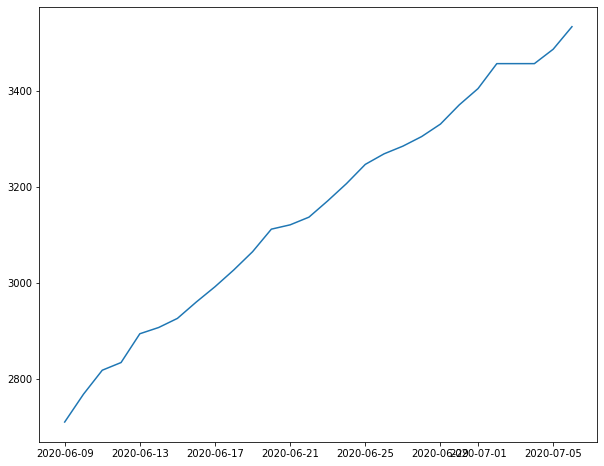

,Date,Deaths
0,2020-06-09,2710
1,2020-06-10,2768
2,2020-06-11,2818
3,2020-06-12,2834
4,2020-06-13,2894
5,2020-06-14,2907
6,2020-06-15,2926
7,2020-06-16,2960
8,2020-06-17,2992
9,2020-06-18,3027


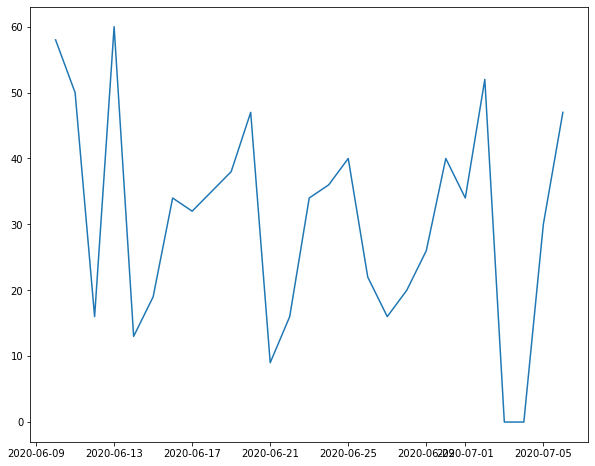

In [30]:
if len(AREA_OF_INTEREST) <= 2:
    area_df, population = datastore.get_time_series_for_area(AREA_OF_INTEREST[0])
else:
    area_df, population = datastore.get_time_series_for_area(
        AREA_OF_INTEREST[0], AREA_OF_INTEREST[2])
    
print('Total population', population)
area_df = area_df[['Date', METRIC]]
train_area_df = area_df[
    (area_df.Date >= MODEL_FIT_FIRST_DATE) & 
    (area_df.Date <= MODEL_FIT_LAST_DATE)][['Date', METRIC]]
train_area_df = train_area_df[train_area_df[METRIC] > 0]
train_area_df = train_area_df.sort_values(by=['Date']).reset_index(drop=True)
# Validate selection through plot and inspection
plt.figure(figsize=(10, 8))
plt.plot(train_area_df['Date'], train_area_df[METRIC])
plt.show()
plt.figure(figsize=(10, 8))
plt.plot(train_area_df['Date'], (train_area_df[['Date', METRIC]]-train_area_df[['Date', METRIC]].shift(1))[METRIC])
train_area_df

dow
0    0.757219
1    1.273009
2    1.356795
3    1.358994
4    0.935113
5    0.903187
6    0.457485
dtype: float64


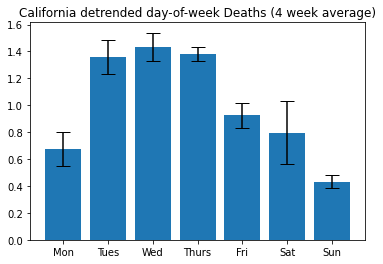

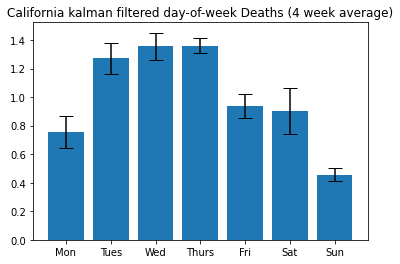

/Users/bfoo/env3/general/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


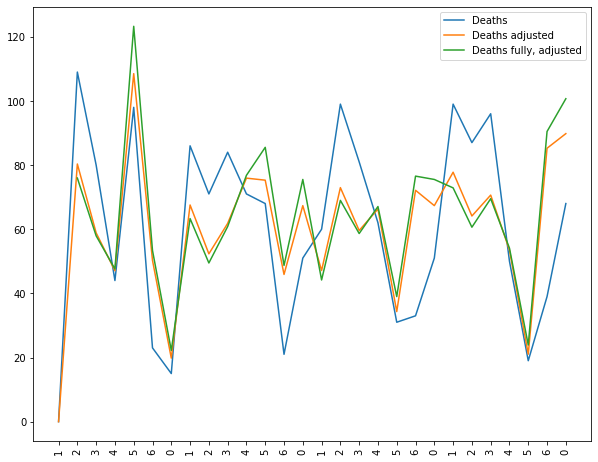

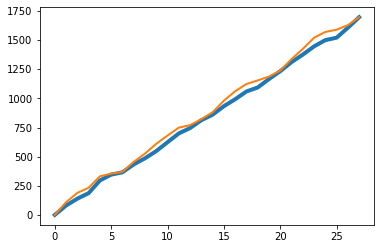

In [14]:
# Detrend by day of week
DAYS_OF_THE_WEEK = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

area_df['dow'] = area_df['Date'].dt.dayofweek
area_df[METRIC + ' diff'] = area_df[METRIC] - area_df[METRIC].shift(1)
area_df[METRIC + ' Squared diff'] = area_df[METRIC + ' diff'] * area_df[METRIC + ' diff']
dow_sum = None
weeks = 4

weekly_sum = 0
weekly_sum_squared = 0
for days_before in range(weeks*7-1, weeks*7+6): #7 days shift
    for week in range(weeks):
        start_date = area_df['Date'].max() + timedelta(-days_before+week*7)
        norm_dow = area_df[
            (area_df['Date'] >= start_date) &
            (area_df['Date'] <= start_date + timedelta(6))
        ][['Date', METRIC, METRIC + ' diff', METRIC + ' Squared diff', 'dow']].groupby('dow').sum()
        dow_mean = norm_dow[METRIC + ' diff'].mean()
        norm_dow[METRIC + ' diff'] /= (dow_mean + 1e-4)
        norm_dow[METRIC + ' diff'] = np.maximum(norm_dow[METRIC + ' diff'], 1e-4)
        norm_dow[METRIC + ' Squared diff'] /= ((dow_mean + 1e-4) ** 2)
        norm_dow[METRIC + ' Squared diff'] = np.maximum(norm_dow[METRIC + ' Squared diff'], 1e-8)
        weekly_sum += norm_dow[METRIC + ' diff'].sum()
        weekly_sum_squared += norm_dow[METRIC + ' Squared diff'].sum()
        if dow_sum is None: # 1 week of data
            dow_sum = norm_dow
        else:
            dow_sum += norm_dow
            
# Total number of samples is weeks * 7, so we take the mean by dividing by weeks * 7
death_mean = dow_sum[METRIC + ' diff'] / weeks / 7
death_err = np.sqrt(dow_sum[METRIC + ' Squared diff'] / weeks / 7 - death_mean * death_mean) / np.sqrt(weeks)
weekly_mean = weekly_sum / weeks / 7 / 7
weekly_err = np.sqrt(weekly_sum_squared / weeks / 7 / 7 - weekly_mean * weekly_mean) / np.sqrt(weeks)
# Apply Gaussian weighted averaging
kf_mean = (death_mean * (1 / death_err ** 2) + weekly_mean * (1 / weekly_err ** 2)
                         ) / ((1 / death_err ** 2) + (1 / weekly_err ** 2))
kf_err = np.sqrt(1 / ((1 / death_err ** 2) + (1 / weekly_err ** 2)))
print(kf_mean)
plt.bar(DAYS_OF_THE_WEEK, death_mean, yerr=death_err, capsize=7)
plt.title(AREA_OF_INTEREST[1] + ' detrended day-of-week ' + METRIC + ' (' + str(weeks) + ' week average)')
plt.show()

plt.bar(DAYS_OF_THE_WEEK, kf_mean, yerr=kf_err, capsize=7)
plt.title(AREA_OF_INTEREST[1] + ' kalman filtered day-of-week ' + METRIC + ' (' + str(weeks) + ' week average)')
plt.show()

diff_df = train_area_df-train_area_df.shift(1)
diff_df['Date'] = train_area_df['Date']
diff_df['dow'] = diff_df['Date'].dt.dayofweek

diff_df[METRIC + ' adjusted'] = diff_df[METRIC] / (diff_df['dow'].apply(lambda x: kf_mean[x]) + 1e-8)
diff_df[METRIC + ' fully adjusted'] = diff_df[METRIC] / (diff_df['dow'].apply(lambda x: death_mean[x]) + 1e-8)
diff_df[METRIC].iloc[0] = 0
diff_df[METRIC + ' adjusted'].iloc[0] = 0

plt.figure(figsize=(10, 8))
plt.plot(diff_df['Date'], diff_df[METRIC], label=METRIC)
plt.plot(diff_df['Date'], diff_df[METRIC + ' adjusted'], label=METRIC + ' adjusted')
plt.plot(diff_df['Date'], diff_df[METRIC + ' fully adjusted'], label=METRIC + ' fully, adjusted')
plt.xticks(diff_df['Date'], diff_df['dow'], rotation='vertical')
plt.legend()
plt.show()

diff_df[METRIC + ' cumsum'] = diff_df[METRIC].cumsum()
diff_df[METRIC + ' adjusted cumsum'] = diff_df[METRIC + ' adjusted'].cumsum()
plt.plot(diff_df[METRIC + ' adjusted cumsum'] * diff_df[METRIC + ' cumsum'].iloc[-1] / diff_df[METRIC + ' adjusted cumsum'].iloc[-1],
         linewidth=4)
plt.plot(diff_df[METRIC + ' cumsum'], linewidth=2)

#train_area_df[METRIC + ' adjusted'] = train_area_df[METRIC].iloc[0] + diff_df[METRIC + ' adjusted cumsum'] * diff_df[METRIC + ' cumsum'].iloc[-1] / diff_df[METRIC + ' adjusted cumsum'].iloc[-1]
train_area_df[METRIC + ' adjusted'] = train_area_df[METRIC]

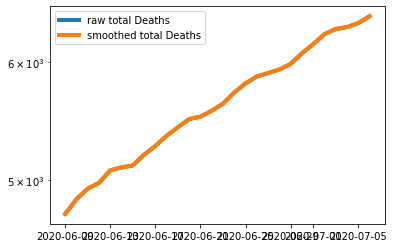

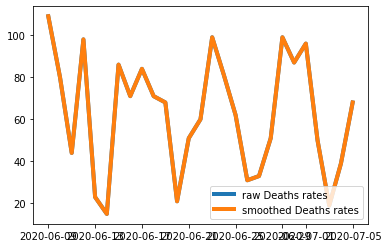

In [15]:
# Optional: Get rid of single day outliers by using a window to limit the outlier slope
# to the second largest/smallest slope
# Rescale to keep the total number of deaths equal.


train_data = dataproc.convert_data_to_numpy(train_area_df, METRIC + ' adjusted', smooth=False)
plt.yscale('log')
plt.plot(train_area_df['Date'], train_area_df[METRIC], linewidth=4, label='raw total ' + METRIC)
plt.plot(train_area_df['Date'], train_data, linewidth=4, label='smoothed total ' + METRIC)
plt.legend()
plt.show()

plt.plot(train_area_df['Date'].iloc[:-1],
         train_area_df[METRIC].iloc[1:].to_numpy() - train_area_df[METRIC].iloc[:-1].to_numpy(),
         linewidth=4, label='raw ' + METRIC + ' rates')
plt.plot(train_area_df['Date'].iloc[:-1],
         train_data[1:] - train_data[:-1],
         linewidth=4, label='smoothed ' + METRIC + ' rates')
plt.legend()

## Fitting Values to the Model

We try to find the best fit of all parameters of the model by minimizing its mean squared error (mse) from actual data points.

Note that the simple algorithm used below is randomized and not guaranteed to be optimal, but in practice, seems to converge to a near optimal solution quickly. Also, approaches such as Bayesian optimization, annealing, and other guaranteed optimal techniques take a long time to run per iteration and have occasionally stalled the notebook.

In [16]:

reload(sir_model)
reload(optimizer)
# Reasonable search regions for each parameter
recovery_days = 10.0 # This is fairly constant

infection_rate_range = [0.001, 0.80]
multiplier_range = [0.01, 10.0]
frac_infected_range = [0.01, 0.99]

best_param, best_value = optimizer.minimize(
    train_data, population, recovery_days,
    pop_frac, infection_rate_range, multiplier_range, frac_infected_range
)
print('Param', best_param)
print('MSE', best_value)

Param [0.10220918 1.00795157 0.13031453]
MSE 706.801972377607


Population fraction susceptible (e.g. would die if infected): 0.006
Population susceptible (e.g. would die if infected): 237073.33800000002
Fraction of infected/recovered population currently infected at start of simulation: 0.1303145319850815
Final population affected (e.g. dead) since start of simulation: 14620.382088807295
Final population affected (e.g. dead) overall: 19365.382088807295
Current and final herd immunity level: 0.02716880799139041 0.08184434585905088
Transmissions per person per day: 0.1022091847818846
First day estimate multiplier 1.0079515659482332
R0 (initial transmit rate / recovery rate) 1.0220918478188459
R (current transmit rate / recovery rate) 0.9943228306558902
Training MSE 706.801972377607
Validation MSE 706.801972377607
2 week numbers 875 fraction
peak infection rate date 2020-06-09 00:00:00


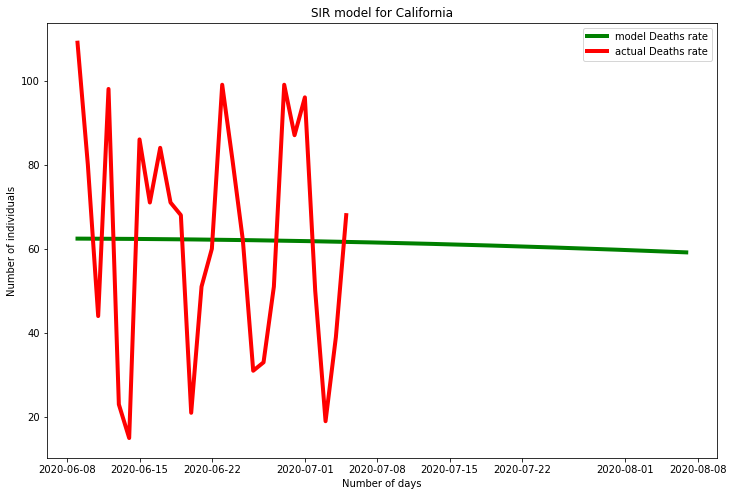

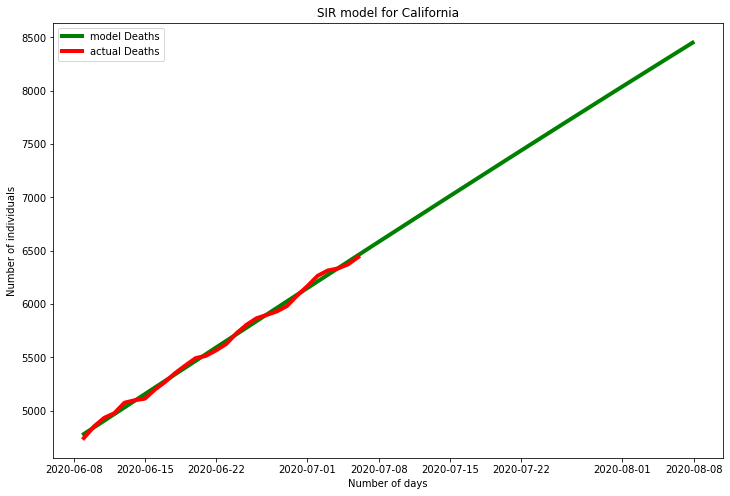

In [17]:
#Validation plot
validation_area_df = area_df # TODO: add holdout days
validation_area_df = validation_area_df[
    (validation_area_df.Date >= MODEL_FIT_FIRST_DATE)
    & (validation_area_df.Date <= MODEL_FIT_LAST_DATE)
]
validation_area_df = validation_area_df[validation_area_df[METRIC] > 0]
validation_area_df = validation_area_df.sort_values(by=['Date']).reset_index(drop=True)

best_infection_rate = best_param[0]
best_multiplier = best_param[1]
best_frac_infected = best_param[2]

infected = train_data[0] * best_multiplier * best_frac_infected
recovered = train_data[0] * best_multiplier * (1 - best_frac_infected)
t, s, i, r = sir_model.compute_sir(
    SAMPLING_RATE,
    SIMULATION_DAYS,
    population * pop_frac,
    infected,
    recovered,
    best_infection_rate,
    recovery_days
)

valid_obj = sir_model.create_objective_fn(
    validation_area_df[METRIC].to_numpy(), population, sampling_rate=SAMPLING_RATE)

validation_mse = valid_obj(pop_frac, best_infection_rate, recovery_days, best_multiplier, best_frac_infected)

print('Population fraction susceptible (e.g. would die if infected):', pop_frac)
print('Population susceptible (e.g. would die if infected):', pop_frac * population)
print('Fraction of infected/recovered population currently infected at start of simulation:', best_frac_infected)
print('Final population affected (e.g. dead) since start of simulation:', (s[0] - s[-1]))
print('Final population affected (e.g. dead) overall:', (train_area_df[METRIC].iloc[0] + s[0] - s[-1]))
print('Current and final herd immunity level:',
      train_data[-1] / pop_frac / population,
      (population * pop_frac - s[-1]) / pop_frac / population)
print('Transmissions per person per day:', best_infection_rate)
print('First day estimate multiplier', best_multiplier)
print('R0 (initial transmit rate / recovery rate)', best_infection_rate * recovery_days)
print('R (current transmit rate / recovery rate)', best_infection_rate * recovery_days * (1 - train_data[-1] / pop_frac / population))
print('Training MSE', best_value)
print('Validation MSE', validation_mse)
print('2 week numbers', np.sum(train_data[-14:] - train_data[-15:-1]), 'fraction')
plot_sir_model(r, i, s, SIMULATION_DAYS, 60, validation_area_df, METRIC, SAMPLING_RATE, AREA_OF_INTEREST[1])

In [27]:
step_size = 24 * 60 * 60 / SAMPLING_RATE
start_time = validation_area_df['Date'].min().timestamp()
sim_end_time = start_time + SIMULATION_DAYS * 86400
sim_timestamps = np.arange(start_time, sim_end_time, step_size)
sim_dates = [datetime.utcfromtimestamp(x) for x in sim_timestamps]
list(zip(sim_dates, r + i))

[(datetime.datetime(2020, 6, 10, 0, 0), 82.75422198269531),
 (datetime.datetime(2020, 6, 10, 2, 24), 82.78386590410554),
 (datetime.datetime(2020, 6, 10, 4, 48), 82.81363000914344),
 (datetime.datetime(2020, 6, 10, 7, 12), 82.8435147836826),
 (datetime.datetime(2020, 6, 10, 9, 36), 82.87352071554957),
 (datetime.datetime(2020, 6, 10, 12, 0), 82.90364829453185),
 (datetime.datetime(2020, 6, 10, 14, 24), 82.93389801238543),
 (datetime.datetime(2020, 6, 10, 16, 48), 82.9642703628427),
 (datetime.datetime(2020, 6, 10, 19, 12), 82.99476584162039),
 (datetime.datetime(2020, 6, 10, 21, 36), 83.02538494642734),
 (datetime.datetime(2020, 6, 11, 0, 0), 83.05612817697241),
 (datetime.datetime(2020, 6, 11, 2, 24), 83.08699603497247),
 (datetime.datetime(2020, 6, 11, 4, 48), 83.11798902416041),
 (datetime.datetime(2020, 6, 11, 7, 12), 83.149107650293),
 (datetime.datetime(2020, 6, 11, 9, 36), 83.1803524211591),
 (datetime.datetime(2020, 6, 11, 12, 0), 83.21172384658759),
 (datetime.datetime(2020, 6